Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - loss: 0.9961 - val_loss: 0.9628
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.9744 - val_loss: 0.9533
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.9510 - val_loss: 0.9489
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.9485 - val_loss: 0.9362
Epoch 5/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9419 - val_loss: 0.9275
Epoch 6/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.9223 - val_loss: 0.9196
Epoch 7/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.9241 - val_loss: 0.9152
Epoch 8/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9149 - val_loss: 0.9108
Epoch 9/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9153 - val_loss: 0.9141
Epoch 10/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9233 - val_loss: 0.9043
Epoch 11/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.9122 - val_loss: 0.9002
Epoch 12/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.8

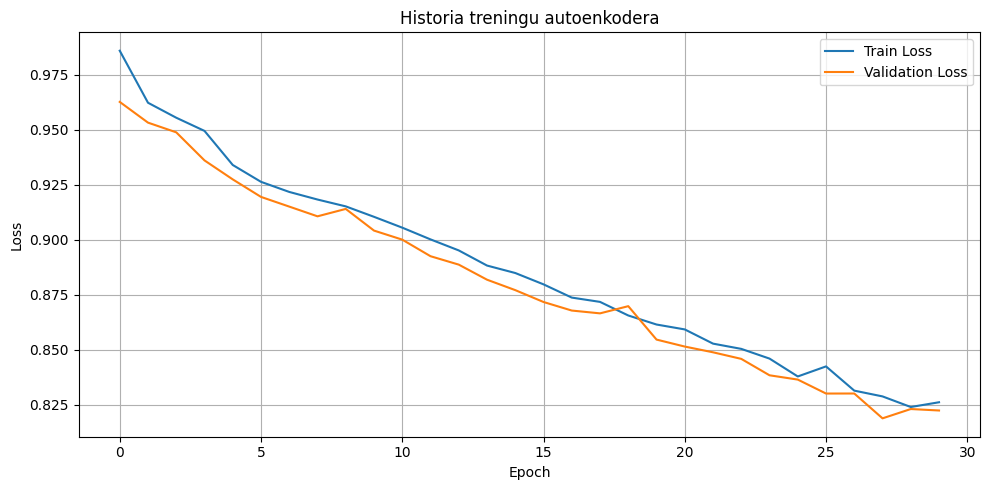

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step
   Reconstruction Error  Anomaly
0              1.211272        0
1              0.682060        0
2              0.406877        0
3              0.958367        0
4              0.904418        0
5              0.702521        0
6              0.907371        0
7              1.047703        0
8              0.918904        0
9              0.775579        0


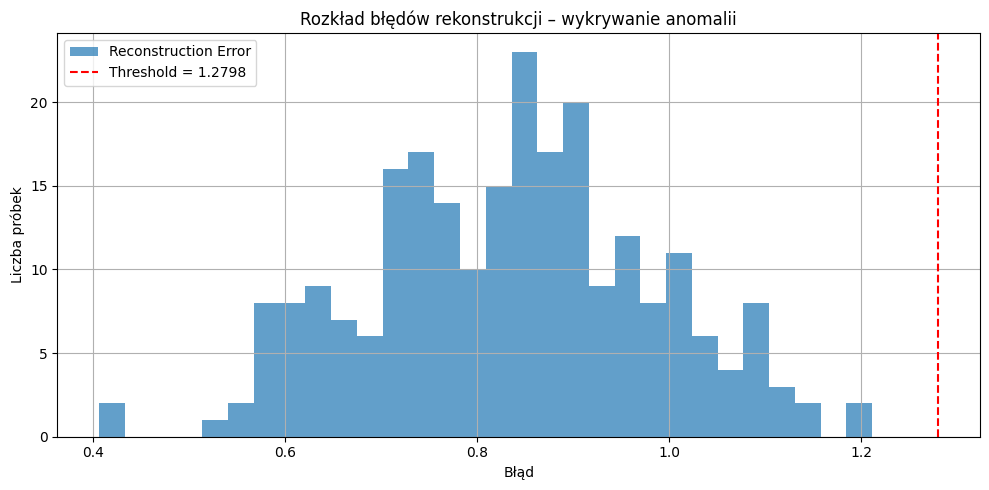

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras import regularizers

# Generowanie danych jak wcześniej
np.random.seed(42)
num_sensors = 10
time_steps = 144
num_features = 3
tensor_data = np.random.normal(loc=[22,50,1013], scale=[1,5,10], size=(num_sensors, time_steps, num_features))

# Normalizacja
tensor_data_reshaped = tensor_data.reshape(-1, num_features)
scaler = StandardScaler()
normalized_data = scaler.fit_transform(tensor_data_reshaped).reshape(num_sensors, time_steps, num_features)

# Tworzenie sekwencji (np. 24h okna)
window_size = 24
X = []
for sensor in range(num_sensors):
    for t in range(time_steps - window_size):
        X.append(normalized_data[sensor, t:t+window_size, :])
X = np.array(X)

# Podział na zbiór treningowy i testowy
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Autoencoder LSTM
timesteps = X_train.shape[1]
features = X_train.shape[2]

input_layer = Input(shape=(timesteps, features))
encoded = LSTM(64, activation='relu', return_sequences=False)(input_layer)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(features))(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Trening
history = autoencoder.fit(X_train, X_train, epochs=30, batch_size=16, validation_split=0.2)

# Wykres strat
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Historia treningu autoenkodera')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predykcja na danych testowych
X_pred = autoencoder.predict(X_test)

# Błąd rekonstrukcji jako wskaźnik anomalii
reconstruction_errors = np.mean((X_test - X_pred)**2, axis=(1,2))

# Ustalmy próg anomalii: np. średnia + 3×odchylenie
threshold = np.mean(reconstruction_errors) + 3*np.std(reconstruction_errors)

# Wykryte anomalie
anomaly_flags = reconstruction_errors > threshold

# Wyniki
results_df = pd.DataFrame({
    'Reconstruction Error': reconstruction_errors,
    'Anomaly': anomaly_flags.astype(int)
})

print(results_df.head(10))

# Wykres błędów
plt.figure(figsize=(10,5))
plt.hist(reconstruction_errors, bins=30, alpha=0.7, label='Reconstruction Error')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.title('Rozkład błędów rekonstrukcji – wykrywanie anomalii')
plt.xlabel('Błąd')
plt.ylabel('Liczba próbek')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

